In [1]:
import os
import re

from dotenv import find_dotenv, load_dotenv
from IPython.display import display, Image
from rich import print as rprint
from rich.markdown import Markdown
from rich.pretty import Pretty
from rich.text import Text

In [2]:
load_dotenv(find_dotenv('.env'))

True

In [3]:
os.environ["LANGCHAIN_PROJECT"] = "RAG From Scratch: Part 15 (Retrieval - CRAG)"

# Retrieval

![](images/retrieval.png)

# Corrective RAG (CRAG)

![](images/15-crag.png)

![](images/15-crag-implementation.png)

## Configure components

In [4]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

In [5]:
llm = ChatOpenAI(
    model="gpt-4.1-mini",
    temperature=1
)
llm.invoke("Hello")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_38647f5e19', 'id': 'chatcmpl-BQDgtAEm4y6znLvsmuLv4mmKKhaKn', 'finish_reason': 'stop', 'logprobs': None}, id='run-472d82bf-d8f4-48a0-a675-21c12dc0c08b-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [6]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
len(embeddings.embed_query("Hello"))

1536

## Load documents

In [7]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [8]:
articles = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

loader = WebBaseLoader(
    web_paths=articles,
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()
len(docs)

3

In [9]:
print(docs[0].page_content[:1000])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:

Planning

Subgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.
Reflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.


Memory

Short-term memory: I 

In [10]:
print(docs[1].page_content[:1000])



      Prompt Engineering
    
Date: March 15, 2023  |  Estimated Reading Time: 21 min  |  Author: Lilian Weng


Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.
This post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of prompt engineering is about alignment and model steerability. Check my previous post on controllable text generation.
[My personal spicy take] In my opinion, some prompt engineering papers are not worthy 8 pages long, since those tricks can be explained in one or a few sentences and the rest is all about benchmarking. An easy-to-use and shared benchmark infrastructure

In [11]:
print(docs[2].page_content[:1000])



      Adversarial Attacks on LLMs
    
Date: October 25, 2023  |  Estimated Reading Time: 33 min  |  Author: Lilian Weng


The use of large language models in the real world has strongly accelerated by the launch of ChatGPT. We (including my team at OpenAI, shoutout to them) have invested a lot of effort to build default safe behavior into the model during the alignment process (e.g. via RLHF). However, adversarial attacks or jailbreak prompts could potentially trigger the model to output something undesired.
A large body of ground work on adversarial attacks is on images, and differently it operates in the continuous, high-dimensional space. Attacks for discrete data like text have been considered to be a lot more challenging, due to lack of direct gradient signals. My past post on Controllable Text Generation is quite relevant to this topic, as attacking LLMs is essentially to control the model to output a certain type of (unsafe) content.
There is also a branch of work on attackin

## Split documents

In [12]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [13]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
splits = text_splitter.split_documents(docs)
len(splits)

180

## Store documents

In [14]:
from langchain_core.vectorstores import InMemoryVectorStore

In [15]:
vectorstore = InMemoryVectorStore(embeddings)
doc_ids = vectorstore.add_documents(documents=splits)
len(doc_ids), len(vectorstore.store)

(180, 180)

In [16]:
retriever = vectorstore.as_retriever()

## RAG

In [17]:
import operator
from typing import Annotated, Literal, TypedDict

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.documents import Document
from langchain_core.messages import HumanMessage
from langchain_core.runnables import chain
from langgraph.graph import END, START, StateGraph
from pydantic import BaseModel, Field

In [18]:
rag_prompt_template = """Answer the following question based on this context:

{context}

Question: {question}
"""
print(rag_prompt_template)

Answer the following question based on this context:

{context}

Question: {question}



In [19]:
grading_prompt_template = """You are a grader assessing relevance of a retrieved document to a user question. 
If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant.
Give a binary score to indicate whether the document is relevant to the question.

Retrieved document:
{document}

User question:
{question}"""

print(grading_prompt_template)

You are a grader assessing relevance of a retrieved document to a user question. 
If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant.
Give a binary score to indicate whether the document is relevant to the question.

Retrieved document:
{document}

User question:
{question}


In [20]:
query_rewriting_prompt_template = """You a question re-writer that converts an input question to a better version that is optimized for web search. 
Look at the input and try to reason about the underlying semantic intent / meaning.

Here is the initial question:
{question}

Formulate an improved question."""

print(query_rewriting_prompt_template)

You a question re-writer that converts an input question to a better version that is optimized for web search. 
Look at the input and try to reason about the underlying semantic intent / meaning.

Here is the initial question:
{question}

Formulate an improved question.


In [21]:
class DocumentGrade(BaseModel):
    """Relevance check on retrieved document."""
    chain_of_thought: str = Field(
        ..., description="Step by step reasoning to check if the document is relevant to the question"
    )
    is_relevant: bool = Field(
        description="Document is relevant to the question"
    )

grader_llm = llm.with_structured_output(DocumentGrade, method="function_calling")

@chain
def grade_document(document, question):
    grading_prompt = grading_prompt_template.format(document=document, question=question)
    response = grader_llm.invoke([HumanMessage(content=grading_prompt)])
    return response

In [22]:
class WebSearchQuery(BaseModel):
    """Question optimization for web search."""
    chain_of_thought: str = Field(
        ..., description="Step by step reasoning to optimize query for web search"
    )
    web_search_query: str = Field(
        description="Optimized web search query"
    )

web_search_llm = llm.with_structured_output(WebSearchQuery, method="function_calling")

In [23]:
web_search_tool = TavilySearchResults(k=4)
rprint(web_search_tool.input_schema.schema())

/tmp/ipykernel_266301/2226099129.py:2: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  rprint(web_search_tool.input_schema.schema())


{
    'description': 'Input for the Tavily tool.',
    'properties': {'query': {'description': 'search query to look up', 'title': 'Query', 'type': 'string'}},
    'required': ['query'],
    'title': 'TavilyInput',
    'type': 'object'
}

In [24]:
def format_docs(docs: list[Document]) -> list[str]:
    return "\n\n".join(doc.page_content for doc in docs)

In [25]:
class State(TypedDict):
    question: str
    documents: list[Document]
    grades: list[DocumentGrade]
    is_web_search_required: bool
    web_search_query: str
    context: Annotated[list[Document], operator.add]
    answer: str

In [26]:
def retrieve(state: State):
    question = state["question"]
    documents = retriever.invoke(question)
    return {"documents": documents}


def grade_documents(state: State):
    question = state["question"]
    documents = state["documents"]

    grades = grade_document.batch(
        documents, question=question
    )
    filtered_documents = [document for (document, grade) in zip(documents, grades) if grade.is_relevant]
    is_web_search_required = len(filtered_documents) < len(documents)
            
    return {"context": filtered_documents, "grades": grades, "is_web_search_required": is_web_search_required}


def check_documents_relevance(state: State) -> Literal["rewrite_query", "generate_answer"]:
    is_web_search_required = state["is_web_search_required"]

    if is_web_search_required:
        return "rewrite_query"
    else:
        return "generate_answer"


def rewrite_query(state: State):
    question = state["question"]
    query_rewriting_prompt = query_rewriting_prompt_template.format(question=question)
    response = web_search_llm.invoke(query_rewriting_prompt)
    return {"web_search_query": response.web_search_query}


def web_search(state: State):
    query = state["web_search_query"]
    results = web_search_tool.invoke({"query": query})
    documents = [Document(page_content=result["content"]) for result in results]
    return {"context": documents}


def generate_answer(state: State):
    docs_content = format_docs(state["context"])
    rag_prompt = rag_prompt_template.format(
        question=state["question"],
        context=docs_content
    )
    response = llm.invoke([
        HumanMessage(content=rag_prompt)
    ])
    return {"answer": response.content}

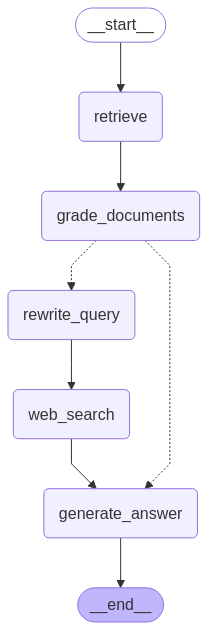

In [27]:
graph_builder = StateGraph(State)

graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("grade_documents", grade_documents)
graph_builder.add_node("rewrite_query", rewrite_query)
graph_builder.add_node("web_search", web_search)
graph_builder.add_node("generate_answer", generate_answer)

graph_builder.add_edge(START, "retrieve")
graph_builder.add_edge("retrieve", "grade_documents")
graph_builder.add_conditional_edges(
    "grade_documents", 
    check_documents_relevance
)
graph_builder.add_edge("rewrite_query", "web_search")
graph_builder.add_edge("web_search", "generate_answer")
graph_builder.add_edge("generate_answer", END)

graph = graph_builder.compile()
graph

In [28]:
query = "What are common types of agent memory?"

response = graph.invoke({"question": query})
rprint(response)
rprint(Markdown(response["answer"]))

{
    'question': 'What are common types of agent memory?',
    'documents': [
        Document(
            id='d98ef1ec-209b-4c0c-b377-ac51f533fca5',
            metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
            page_content='Short-term memory: I would consider all the in-context learning (See Prompt Engineering) 
as utilizing short-term memory of the model to learn.\nLong-term memory: This provides the agent with the 
capability to retain and recall (infinite) information over extended periods, often by leveraging an external 
vector store and fast retrieval.\n\n\nTool use\n\nThe agent learns to call external APIs for extra information that
is missing from the model weights (often hard to change after pre-training), including current information, code 
execution capability, access to proprietary information sources and more.'
        ),
        Document(
            id='1f7e4957-8dd6-4ded-99c4-b40cd129d29c',
            metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
            page_content='Memory stream: is a long-term memory module (external database) that records a 
comprehensive list of agents’ experience in natural language.\n\nEach element is an observation, an event directly 
provided by the agent.\n- Inter-agent communication can trigger new natural language statements.\n\n\nRetrieval 
model: surfaces the context to inform the agent’s behavior, according to relevance, recency and 
importance.\n\nRecency: recent events have higher scores\nImportance: distinguish mundane from core memories. Ask 
LM directly.\nRelevance: based on how related it is to the current situation / query.\n\n\nReflection mechanism: 
synthesizes memories into higher level inferences over time and guides the agent’s future behavior. They are 
higher-level summaries of past events (<- note that this is a bit different from self-reflection above)'
        ),
        Document(
            id='6e45bc8b-2550-4f2c-95d3-fe18ca564fa9',
            metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
            page_content='Fig. 7. Comparison of AD, ED, source policy and RL^2 on environments that require memory 
and exploration. Only binary reward is assigned. The source policies are trained with A3C for "dark" environments 
and DQN for watermaze.(Image source: Laskin et al. 2023)\nComponent Two: Memory#\n(Big thank you to ChatGPT for 
helping me draft this section. I’ve learned a lot about the human brain and data structure for fast MIPS in my 
conversations with ChatGPT.)\nTypes of Memory#\nMemory can be defined as the processes used to acquire, store, 
retain, and later retrieve information. There are several types of memory in human brains.\n\n\nSensory Memory: 
This is the earliest stage of memory, providing the ability to retain impressions of sensory information (visual, 
auditory, etc) after the original stimuli have ended. Sensory memory typically only lasts for up to a few seconds. 
Subcategories include iconic memory (visual), echoic memory (auditory), and haptic memory (touch).'
        ),
        Document(
            id='cf43b2ec-9978-4407-bc88-721c5bb0d22f',
            metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
            page_content='Sensory memory as learning embedding representations for raw inputs, including text, 
image or other modalities;\nShort-term memory as in-context learning. It is short and finite, as it is restricted 
by the finite context window length of Transformer.\nLong-term memory as the external vector store that the agent 
can attend to at query time, accessible via fast retrieval.\n\nMaximum Inner Product Search (MIPS)#\nThe external 
memory can alleviate the restriction of finite attention span.  A standard practice is to save the embedding 
representation of information into a vector store database that can support fast maximum inner-product search 
(MIPS). To optimize the retrieval s

Common types of agent memory include:                                                                              

 1 Sensory Memory                                                                                                  
    • The earliest stage of memory that retains impressions of sensory information (visual, auditory, etc.) for a  
      very short duration (a few seconds).                                                                         
    • In agents, this can correspond to learning embedding representations for raw inputs such as text, images, or 
      other modalities.                                                                                            
 2 Short-term Memory                                                                                               
    • Corresponds to in-context learning, where the model utilizes the current context (prompt) to learn or adapt  
      behavior temporarily.                                                                                        
    • It is short and finite, limited by the context window length of the Transformer model.                       
 3 Long-term Memory                                                                                                
    • An external memory module, often implemented as a vector store, that retains and allows retrieval of         
      information over extended periods, beyond the immediate context.                                             
    • Supports fast retrieval methods such as Maximum Inner Product Search (MIPS) using approximate nearest        
      neighbors (ANN) algorithms to efficiently surface relevant memories during a query.                          

These memory types enable an agent to acquire, store, retain, and recall information for improved performance in   
various tasks.

In [29]:
query = "What are main steps for collecting human data?"

response = graph.invoke({"question": query})
rprint(response)
rprint(Markdown(response["answer"]))

{
    'question': 'What are main steps for collecting human data?',
    'documents': [
        Document(
            id='4c5405bf-80ee-4221-b156-0134c1a84ca7',
            metadata={'source': 'https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/'},
            page_content='Casper et al. (2023) set up a human-in-the-loop red teaming process. The main difference 
from Perez et al. (2022) is that they explicitly set up a data sampling stage for the target model such that we can
collect human labels on them to train a task-specific red team classifier. There are three steps:'
        ),
        Document(
            id='48e5c5ca-2d73-4cdc-bae5-fced9819183b',
            metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
            page_content="With the input and the inference results, the AI assistant needs to describe the process 
and results. The previous stages can be formed as - User Input: {{ User Input }}, Task Planning: {{ Tasks }}, Model
Selection: {{ Model Assignment }}, Task Execution: {{ Predictions }}. You must first answer the user's request in a
straightforward manner. Then describe the task process and show your analysis and model inference results to the 
user in the first person. If inference results contain a file path, must tell the user the complete file path."
        ),
        Document(
            id='5b2c0179-3048-4680-8279-217461c5765c',
            metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
            page_content='Resources:\n1. Internet access for searches and information gathering.\n2. Long Term 
memory management.\n3. GPT-3.5 powered Agents for delegation of simple tasks.\n4. File output.\n\nPerformance 
Evaluation:\n1. Continuously review and analyze your actions to ensure you are performing to the best of your 
abilities.\n2. Constructively self-criticize your big-picture behavior constantly.\n3. Reflect on past decisions 
and strategies to refine your approach.\n4. Every command has a cost, so be smart and efficient. Aim to complete 
tasks in the least number of steps.'
        ),
        Document(
            id='fac5d7aa-9a90-4f13-b0c8-858028ffa9d9',
            metadata={'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/'},
            page_content='Question clustering: Embed questions and run $k$-means for clustering.\nDemonstration 
selection: Select a set of representative questions from each cluster; i.e. one demonstration from one cluster. 
Samples in each cluster are sorted by distance to the cluster centroid and those closer to the centroid are 
selected first.\nRationale generation: Use zero-shot CoT to generate reasoning chains for selected questions and 
construct few-shot prompt to run inference.'
        )
    ],
    'grades': [
        DocumentGrade(
            chain_of_thought="The retrieved document mentions a human-in-the-loop red teaming process by Casper et 
al. (2023) and highlights that they explicitly set up a data sampling stage to collect human labels for training a 
task-specific red team classifier. The document then starts listing 'There are three steps:', presumably outlining 
the main steps for the data collection process. This is directly relevant to the user question asking about the 
main steps for collecting human data as it describes a process involving human data collection steps.",
            is_relevant=True
        ),
        DocumentGrade(
            chain_of_thought="The document describes a process involving user input, task planning, model 
selection, and task execution, but it relates to how an AI assistant processes inference and responses rather than 
the specific steps for collecting human data. There is no mention of data collection, human data, or related steps 
in the document content. Therefore, it does not address the user's question about the main steps for collecting 
human data.",
            is_relevant=False
        ),
        DocumentGrade

The main steps for collecting human data, based on the provided context, are:                                      

 1 Define the aim of your research                                                                                 
    • Identify exactly what you want to achieve.                                                                   
    • Write a problem statement describing the practical or scientific issue you want to address and why it        
      matters.                                                                                                     
    • Formulate clear research questions to guide data collection.                                                 
 2 Choose your data collection method                                                                              
    • Select an appropriate method based on your research questions, such as experiments, surveys, interviews,     
      observations, focus groups, etc.                                                                             
    • Ensure the chosen method effectively helps answer your research questions.                                   
 3 Plan your data collection procedures                                                                            
    • Develop a detailed plan or standard operating procedure (SOP) outlining how you will collect, handle, and    
      store data.                                                                                                  
    • Address handling of different data forms (paper, electronic, audio, etc.).                                   
    • Plan for maintaining confidentiality and data security (e.g., de-identification, encryption, restricted      
      access).                                                                                                     
 4 Collect the data                                                                                                
    • Implement your planned data collection process following the SOP.                                            
    • Collect only the minimum necessary data to answer your questions.                                            
    • Ensure data are collected ethically, maintaining participant confidentiality and data integrity.             

These steps align with good research practice and ensure that human data collection is systematic, ethical, and    
useful for answering research questions.

In [30]:
query = "How does the AlphaCodium paper work?"

response = graph.invoke({"question": query})
rprint(response)
rprint(Markdown(response["answer"]))

{
    'question': 'How does the AlphaCodium paper work?',
    'documents': [
        Document(
            id='375e96e9-9bdd-4118-b23c-bd132675a3b6',
            metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
            page_content='Case Studies#\nScientific Discovery Agent#\nChemCrow (Bran et al. 2023) is a 
domain-specific example in which LLM is augmented with 13 expert-designed tools to accomplish tasks across organic 
synthesis, drug discovery, and materials design. The workflow, implemented in LangChain, reflects what was 
previously described in the ReAct and MRKLs and combines CoT reasoning with tools relevant to the tasks:\n\nThe LLM
is provided with a list of tool names, descriptions of their utility, and details about the expected 
input/output.\nIt is then instructed to answer a user-given prompt using the tools provided when necessary. The 
instruction suggests the model to follow the ReAct format - Thought, Action, Action Input, Observation.'
        ),
        Document(
            id='9b7dfc8c-7b4a-4a25-9892-752f5475cc97',
            metadata={'source': 'https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/'},
            page_content='Effectiveness is measured by attack objective functions designed for different 
experiments:\n- In text-to-image experiment, they used Q16 (Schramowski et al. 2022) and NudeNet 
(https://github.com/notAI-tech/NudeNet).\n- text-to-text experiment: TOXIGEN\nDiversity is measured by pairwise 
dissimilarity, in form of $\\sum_{(\\mathbf{x}_i, \\mathbf{x}_j) \\in \\text{All pairs}} [1 - 
\\text{sim}(\\mathbf{x}_i, \\mathbf{x}_j)]$\nLow-toxicity is measured by Perspective API.\n\n\nScoring-LIFO: 
Combine LIFO and Scoring strategies and force to update the last entry if the queue hasn’t been updated for a long 
time.'
        ),
        Document(
            id='2e721529-44bb-4ba8-b9f1-f55e8bc667e0',
            metadata={'source': 'https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/'},
            page_content='Fig. 9. Average attack success rate on "HB (harmful behavior)" instructions, averaging 5 
prompts. Two baselines are "HB" prompt only or HB prompt followed by `"Sure here\'s"` as a suffix. "Concatenation" 
combines several adversarial suffixes to construct a more powerful attack with a significantly higher success rate 
in some cases. "Ensemble" tracks if any of 5 prompts and the concatenated one succeeded. (Image source: Zou et al. 
2023)\nARCA (“Autoregressive Randomized Coordinate Ascent”; Jones et al. 2023) considers a broader set of 
optimization problems to find input-output pairs $(\\mathbf{x}, \\mathbf{y})$ that match certain behavior pattern; 
such as non-toxic input starting with "Barack Obama" but leading to toxic output. Given an auditing objective 
$\\phi: \\mathcal{X} \\times \\mathcal{Y} \\to \\mathbb{R}$ that maps a pair of (input prompt, output completion) 
into scores. Examples of behavior patterns captured by $\\phi$ are as follows:'
        ),
        Document(
            id='353ce5dd-accf-45c9-aa64-98025d088ecb',
            metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
            page_content='Fig. 4. Experiments on AlfWorld Env and HotpotQA. Hallucination is a more common failure 
than inefficient planning in AlfWorld. (Image source: Shinn & Labash, 2023)'
        )
    ],
    'grades': [
        DocumentGrade(
            chain_of_thought='The user question asks about the workings of the AlphaCodium paper. The retrieved 
document talks about ChemCrow, an LLM augmented with expert-designed tools for tasks in organic synthesis, drug 
discovery, and materials design. It mentions LangChain, ReAct, MRKLs, and CoT reasoning, but makes no mention of 
AlphaCodium or any paper connected to it. Therefore, the document content is unrelated to the AlphaCodium paper 
question.',
            is_relevant=False
        ),
        DocumentGrade(
            chain_of_thought="The user quest

The AlphaCodium paper proposes a novel method to improve code generation by large language models (LLMs) through a 
structured, iterative workflow centered on test-based refinement. The approach is divided into two main phases:    

 1 Pre-processing Phase:                                                                                           
    • AlphaCodium begins by thoroughly reasoning about the problem in natural language.                            
    • It generates multiple potential solution candidates described in natural language and ranks them based on    
      criteria like complexity and robustness.                                                                     
    • This phase emphasizes better understanding and problem specification, breaking down complex problems into    
      simpler subtasks (utilizing a divide and conquer strategy akin to chain-of-thought reasoning but tailored for
      code generation).                                                                                            
 2 Code Iterations Phase:                                                                                          
    • From the solution candidates, AlphaCodium uses language models to generate actual code implementations.      
    • It runs these generated codes against both existing public tests and additional AI-generated test cases,     
      which enhance coverage and test diversity.                                                                   
    • AlphaCodium iteratively analyzes test failures, fixes errors, and reruns the code until all tests pass or    
      iteration limits are reached.                                                                                
    • This iterative testing and fixing cycle ensures a progressively refined, more accurate solution.             

Key elements enabling the flow to work effectively include:                                                        

 • Generating additional data such as problem reflections and test reasoning to aid iterative debugging.           
 • Enriching the test suite by adding AI-generated tests alongside public tests, increasing the rigor and coverage 
   of validation.                                                                                                  
 • Treating natural language prompting as a higher-level programming layer, effectively guiding language models    
   through a multi-stage iterative algorithm without additional model training.                                    
 • Reducing computational cost while improving accuracy, enabling significant performance gains (e.g., improving   
   GPT-4’s accuracy on a competitive programming dataset from 19% to 44% pass@5).                                  

In summary, AlphaCodium works by combining careful problem understanding, multi-stage code generation, and rigorous
iterative testing and fixing. This flow engineering approach transforms prompting strategies into an effective     
algorithmic process, significantly enhancing code generation quality without extra model training or expensive     
computations.